In [1]:
import os
import re
import gensim
from nltk.corpus import stopwords
from preproccess_text import clean_text

In [ ]:
def preproccess_text(text: str) -> list:
    text = re.sub('[«»()!,;:.\s-]', ' ', text)
    return gensim.utils.simple_preprocess(text, min_len=2, max_len=15)

In [3]:
root_path = 'C:\\Users\\edbon\\devproj\\faiky-tails\\dataset\\raw\\'
corpus = []

for _, dirs, files in os.walk(root_path):
    for file in files:
        with open(root_path + file, 'r', encoding='utf-8') as f:
            doc = clean_text(f.read())
        corpus.append(doc.split()) 

In [4]:
corp_size = [len(doc) for doc in corpus]
print(corp_size)

[242, 118, 319, 443, 104, 621, 603, 353, 205, 69, 177, 479, 673, 96, 523, 427, 885, 728, 158, 1207, 265, 624, 202, 478, 160, 97, 38, 183, 291, 533, 456, 611, 399, 464, 285, 649, 237, 352, 168, 521, 472, 70, 135, 614, 296, 263, 205, 740, 710, 159, 149, 756, 152, 64, 116, 335, 75, 703, 553, 168, 96, 114, 125, 1873, 76, 882, 110, 97, 612, 220, 618, 197, 206, 478, 273, 2270, 268, 63, 366, 246, 4687, 127, 1093, 75, 340, 744, 3803, 991, 98, 213, 338, 462, 1959, 87, 289, 2298, 483, 503, 608, 338, 385, 510, 474, 235, 589, 2434, 963, 2375, 927, 803, 3893, 355, 1478, 610, 3335, 735, 255, 813, 431, 1524, 1995, 3578, 2548, 1932, 364, 301, 277, 242, 372, 891, 1570, 483, 2625, 476, 368, 906, 411, 457, 840, 494, 438, 823, 301, 235, 1502, 222, 688, 1072, 370, 634, 652, 1328, 364, 1608, 1238, 1902, 2295, 190, 1246, 74, 1181, 1453, 765, 1002, 500, 102, 611, 197, 118, 234, 1418, 940, 145, 334, 110, 1084, 208, 536, 455, 152, 226, 307, 104, 400, 85, 369, 928, 398, 131, 429, 102, 317, 529, 181, 227, 239, 14

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

sr = pd.Series(corp_size)
print('All tokens=', sr.sum())
print('Size=', sr.count())
print('Mean=', sr.mean())
print('Median=', sr.median())
print('Moda=', sr[sr.mode()].values)
print('Min=', sr.min())
print('Max=', sr.max())
print('Std=', sr.std())
# sr.plot()
print()

All tokens= 231687
Size= 360
Mean= 643.575
Median= 399.5
Moda= [474 364 178  25 501  85]
Min= 21
Max= 4687
Std= 706.706082749783



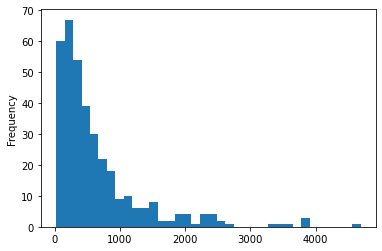

In [34]:
sr.plot.hist(bins=36, figsize=(6,4))
plt.savefig('test.jpg')

In [ ]:
print(corpus[0][:50])

# NLTK

In [ ]:
import nltk, 
import re
import pprint
from nltk import word_tokenize, FreqDist, bigrams


In [ ]:
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('rte')

In [ ]:
text1 = re.sub("[\n]", ' ', text1)

## Tokenize

In [ ]:
tokens = word_tokenize(text1, language='russian')
sents = nltk.sent_tokenize(text1, language='russian')

sents_tokens = [word_tokenize(sent) for sent in sents]

print(len(sents))
print(sents_tokens)
# pprint.pprint(sents_tokens)

## Text simple analyze

In [ ]:
text = nltk.Text(tokens=tokens)

In [ ]:
print(text.collocations())

In [ ]:
print(list(bigrams((text))))

In [ ]:
 fdist1 = FreqDist(text)

In [ ]:
print(fdist1.most_common(30))
fdist1.plot(50, cumulative=True)

## POS TAGS

In [ ]:
sent_tags = nltk.pos_tag_sents(sents_tokens, lang='rus')
pprint.pprint(sent_tags)

In [ ]:
tags = nltk.pos_tag(tokens, lang='rus')
print(tags)

## RTE extractor

In [ ]:
def rte_features(rtepair):
    extractor = nltk.RTEFeatureExtractor(rtepair)
    features = {}
    features['word_overlap'] = len(extractor.overlap('word'))
    features['word_hyp_extra'] = len(extractor.hyp_extra('word'))
    features['ne_overlap'] = len(extractor.overlap('ne'))
    features['ne_hyp_extra'] = len(extractor.hyp_extra('ne'))
    return features

In [ ]:
rtepair = nltk.corpus.rte.pairs(['rte3_dev.xml'])[33]
extractor = nltk.RTEFeatureExtractor(rtepair)
print(extractor.overlap(toktype='ne'))

## Confusion matrix

In [ ]:
from nltk.corpus import brown
t2 = nltk.UnigramTagger(brown.tagged_sents(categories='editorial'))

def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]

def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

gold = tag_list(brown.tagged_sents(categories='editorial'))
test = tag_list(apply_tagger(t2, brown.tagged_sents(categories='editorial')))
cm = nltk.ConfusionMatrix(gold, test)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

In [ ]:
nltk.downloader.download_gui()

## Parsing With Context Free Grammar

In [ ]:
## Для русского не найдены граммеры
grammar = nltk.parse_cfg("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)
rd_parser = nltk.RecursiveDescentParser(TestGrammar)
for tree in rd_parser.parse(sents_tokens[0]):
    print(tree)

# Gensim

In [ ]:
from gensim.models import doc2vec
from gensim import similarities
from gensim import corpora
import random
from copy import copy
from collections import Counter

In [ ]:
dictionary = corpora.Dictionary(corpus)
dictionary.save('./dataset/tails.dict')
print(dictionary.num_docs)
print(dictionary.num_nnz)
print(dictionary.num_pos)

In [ ]:
dictionary.filter_extremes()
print(dictionary.num_docs)
print(dictionary.num_nnz)
print(dictionary.num_pos)

## BoW, TfIdf, LSI

In [ ]:
def most_simillar(model, target, corpus, documents):    
    vec_bow = dictionary.doc2bow(target)
    vec = model[vec_bow]
    # print(vec_lsi)

    index = similarities.MatrixSimilarity(model[corpus])
    sims = index[vec]  # perform a similarity query against the corpus
    # print(list(enumerate(sims)))
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    print("new vector:", target)
    print()
    for doc_position, doc_score in sims[:1]:
        print(doc_score, documents[doc_position])
    return ' '.join(documents[doc_position])

In [ ]:
# порядок слов не учитывается в BoW
bow_corpus = [dictionary.doc2bow(text) for text in corpus]
corpora.MmCorpus.serialize('./dataset/tails.mm', bow_corpus)  # store to disk, for later use

In [ ]:
model_lsi = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=300)

In [ ]:
#doc = preproccess_text("Царь лежал на диване и потягивал смузи. В дом зашел Кащей и начал разговор.")
doc = corpus[0][:20]
doc_pred = most_simillar(model=model_lsi, target=doc, corpus=bow_corpus, documents=corpus)

In [ ]:
model_tfidf = gensim.models.TfidfModel(bow_corpus, normalize=True)
tf_corpus = model_tfidf[bow_corpus]
model_lsi_tf = gensim.models.LsiModel(corpus=tf_corpus, num_topics=300, id2word=dictionary)

In [ ]:
# doc = "Царь лежал на диване и потягивал смузи. В дом зашел Кащей и начал разговор.".lower().split()

doc = corpus[0].copy()
doc = random.choices(doc, k=30)

doc_pred = most_simillar(model=model_lsi_tf, target=doc, corpus=tf_corpus, documents=corpus)

In [ ]:
# doc = "Царь лежал на диване и потягивал смузи. В дом зашел Кащей и начал разговор.".lower().split()
doc = corpus[0][:20]
doc_pred = most_simillar(model=model_tfidf, target=doc, corpus=tf_corpus, documents=corpus)

## Word2Vec

Unfortunately, the model is unable to infer vectors for unfamiliar words. This is one limitation of Word2Vec: if this limitation matters to you, check out the FastText model.

In [ ]:
model = gensim.models.Word2Vec(epochs=20, vector_size=100, window=5, min_count=1)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
from pyemd import emd
word_vectors = model.wv
sentence1 = corpus[0][:10]
sentence2 = corpus[1][:20]
print("sentence1=", sentence1)
print("sentence2=", sentence2)
similarity = word_vectors.wmdistance(sentence1, sentence2)
print(f"wmdistance={similarity:.4f}")

similarity = word_vectors.n_similarity(sentence1, sentence2)
print(f"n_similarity={similarity:.4f}")
0.7067

distance = word_vectors.distance('царь', 'кощей')
print(f"'царь - кощей' distance={distance:.1f}")

vector = word_vectors.get_vector('кощей', norm=True)
print('кощей', vector.shape)
# (100,)

print(f'"баба старик ведро" doesnt_match={word_vectors.doesnt_match("баба старик ведро".split())}')

In [ ]:
model.predict_output_word(['баба'], topn=10)

In [ ]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

### W2V Phrases

In [ ]:
from gensim.models import Phrases

bigram_transformer = Phrases(corpus)

model_bigram = gensim.models.Word2Vec(bigram_transformer[corpus], min_count=1)

In [ ]:
x_vals, y_vals, labels = reduce_dimensions(model_bigram)
plot_function(x_vals, y_vals, labels)

### ruscorpora word2vec

In [ ]:
ruscorpora_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

In [ ]:
list(ruscorpora_vectors.key_to_index.keys())[:10]

In [ ]:
import zipfile
import wget

model_path = 'c:/models/rusvector/'
model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
m = wget.download(model_url, out=model_path)
model_file = model_path + model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [ ]:
list(model.key_to_index.keys())[:10]

In [ ]:
# надо суффикс проставлять для слова с частеречием
vec1 = model.most_similar(positive=['один_NUM'])
print(vec1)

## Doc2Vec

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
train_data = corpus[:round(len(corpus) * 0.8)]
test_data = corpus[round(len(corpus) * 0.8):]
print(len(train_data), len(test_data))

train_corpus = [gensim.models.doc2vec.TaggedDocument(tokens, [i]) for i, tokens in enumerate(train_data)]

In [ ]:
print(train_corpus[0])

In [ ]:
model_d2v = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)
model_d2v.build_vocab(train_corpus)

In [ ]:
model_d2v.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
vector = model_d2v.infer_vector(corpus[0][:10])
print(vector)

In [ ]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model_d2v.infer_vector(train_corpus[doc_id].words)
    sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [ ]:
import collections

counter = collections.Counter(ranks)
print(counter)

In [ ]:
doc_id = random.choice(range(len(train_corpus)))
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
inferred_vector = model_d2v.infer_vector(train_corpus[doc_id].words)
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))
for label, index in sims[:3]:
    print(f'{label} {index:2.2%}: {" ".join(train_corpus[label].words)}')
    print()

### !! убрать надо ударения в словах

In [ ]:
doc_id = random.randint(0, len(test_data) - 1)
inferred_vector = model_d2v.infer_vector(test_data[doc_id])
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))

print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_data[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model_d2v)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

## FastText

Особенности:

* фастекст определяет векторы подстрок входящих в слово и выдает суммарный вектор на их основе. 
* В отличии от w2v может обрабатывать слова не из словаря если хотя бы одна из подстрок этого слова (к примеру корень) есть в векторном пространстве

In [ ]:
model_ft = gensim.models.FastText(vector_size=100)

# build the vocabulary
model_ft.build_vocab(corpus)

# train the model
model_ft.train(
    corpus, 
    epochs=model_ft.epochs,
    total_examples=model_ft.corpus_count, 
    total_words=model_ft.corpus_total_words,
)

print(model_ft)

In [ ]:
wv = model_ft.wv
print(wv)

print('путин' in wv.key_to_index)
try:
    word = 'путин'
    print(wv[word])

except KeyError as err:
    print(err)

print(wv.similarity("путь", "путин"))
print(wv.most_similar("путь"))

In [ ]:
sentence1 = corpus[0][:10]
sentence2 = corpus[10][:20]
print(wv.n_similarity(sentence1, sentence2))
distance = wv.wmdistance(sentence1, sentence2)
print(f"Word Movers Distance is {distance} (lower means closer)")

## Word Movers Distance

In [ ]:
print('Word Movers Distance on fastText')
sentence1 = corpus[0][:10]
sentence2 = preproccess_text('сегодня в новостях опять кого то убили ни за что, а ведь он мог учиться в университете')
print('sentence1', sentence1)
print('sentence2', sentence2)
distance = wv.wmdistance(sentence1, sentence2)
print(f"Word Movers Distance is {distance} (lower means closer)")

In [ ]:
word_vectors_d2v = model_d2v.wv
print('Word Movers Distance on Doc2Vec')
sentence1 = corpus[0][:10]
# sentence2 = preproccess_text('сегодня в новостях опять кого то убили ни за что, а ведь он мог учиться в университете')
sentence2 = corpus[0][5:15]
print('sentence1', sentence1)
print('sentence2', sentence2)
distance = word_vectors_d2v.wmdistance(sentence1, sentence2)
print(f"Word Movers Distance is {distance} (lower means closer)")

## Soft Cosine Measure

In [ ]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex, SoftCosineSimilarity

In [ ]:
print('Word Movers Distance on Doc2Vec')
sentence1 = corpus[0][:20]
sentence2 = corpus[0][20:40]
sentence3 = preproccess_text('сегодня в новостях опять кого то убили ни за что, а ведь он мог учиться в университете')
print('sentence1', sentence1)
print('sentence2', sentence2)
print('sentence3', sentence3)



In [ ]:
model = gensim.models.Word2Vec(epochs=20, vector_size=100, window=5, min_count=1)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
termsim_index = WordEmbeddingSimilarityIndex(model.wv)
dictionary = gensim.corpora.Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(document) for document in corpus]
similarity_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary)

In [ ]:
sent_1 = dictionary.doc2bow(sentence1)
sent_2 = dictionary.doc2bow(sentence2)
sent_3 = dictionary.doc2bow(sentence3)
print(sentence1, '\n', sentence2)
similarity = similarity_matrix.inner_product(sent_1, sent_2, normalized=(True, True))
print('similarity = %.4f' % similarity)
print()
print(sentence1, '\n', sentence3)
similarity = similarity_matrix.inner_product(sent_1, sent_3, normalized=(True, True))
print('similarity = %.4f' % similarity)
print()
print(sentence1, '\n', sentence1)
similarity = similarity_matrix.inner_product(sent_1, sent_1, normalized=(True, True))
print('similarity = %.4f' % similarity)

In [2]:
import pickle
import zipfile
import wget
from preproccess_text import tag_ud

In [ ]:
сorpus_file = "./dataset/corpus.txt"
# with open(corpus_file, "wb") as f:
#     pickle.dump(corpus, f)

with open(сorpus_file, "rb") as f:   # Unpickling
    corpus = pickle.load(f)

In [4]:
corpus = []
stops = set(stopwords.words('russian'))
root_path = 'C:\\Users\\edbon\\devproj\\faiky-tails\\dataset\\raw\\'
modelfile = './udpipe_syntagrus.model'
with open(root_path + '001 Арысь - поле.txt', 'r', encoding='utf-8') as f:
    doc = tag_ud(text=f.read(), modelfile=modelfile, stop_words=stops, keep_pos=True, keep_punct=False)
corpus.append(doc)

In [5]:
model_path = 'c:/models/rusvector/'
model_file = model_path + '180.zip'
if not os.path.exists(model_file):
    model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
    m = wget.download(model_url, out=model_path)
    model_file = model_path + model_url.split('/')[-1]

with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model_rv = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [18]:
print(stops)

{'почти', 'над', 'тогда', 'с', 'при', 'вдруг', 'теперь', 'без', 'после', 'про', 'сейчас', 'как', 'по', 'кто', 'есть', 'тем', 'вот', 'что', 'мой', 'какая', 'она', 'тут', 'ведь', 'нет', 'сам', 'всегда', 'всю', 'впрочем', 'перед', 'потому', 'зачем', 'свою', 'и', 'а', 'так', 'чтобы', 'не', 'да', 'была', 'тебя', 'ему', 'вам', 'может', 'конечно', 'вы', 'со', 'из', 'то', 'него', 'чем', 'иногда', 'более', 'мне', 'этого', 'на', 'один', 'ее', 'разве', 'того', 'два', 'эту', 'об', 'нее', 'всех', 'там', 'под', 'будет', 'были', 'его', 'все', 'ли', 'ничего', 'они', 'уж', 'чтоб', 'опять', 'меня', 'эти', 'всего', 'куда', 'моя', 'лучше', 'много', 'у', 'вас', 'для', 'мы', 'или', 'ней', 'во', 'чего', 'надо', 'какой', 'уже', 'чуть', 'от', 'хорошо', 'еще', 'совсем', 'был', 'никогда', 'тот', 'он', 'можно', 'ни', 'этой', 'ну', 'нас', 'о', 'этом', 'до', 'себя', 'через', 'раз', 'быть', 'больше', 'ж', 'за', 'бы', 'но', 'потом', 'ты', 'хоть', 'между', 'этот', 'даже', 'когда', 'будто', 'такой', 'нибудь', 'том', 'н

In [12]:
# надо суффикс проставлять для слова с частеречием

bad_words = set()
for word in corpus[0]:
    try:
        model_rv[word]
    except KeyError as err:
        bad_words.add(word)
print(bad_words)

for word in bad_words:
    w = word.split('_')[0]
    
    if w in stops:
        print(word)

{'арысь_NOUN', 'весь_DET', 'невзлюбить_PROPN', 'стариковый_ADJ', 'свой_DET', 'падчерицыный_ADV', 'вместо_ADP', 'никто_PRON'}
арысь
весь
невзлюбить
стариковый
свой
падчерицыный
вместо
никто
